# 1 Task Understanding

Вам необходимо решить модельный бизнес кейс от некоторого заказчика - строительной компании, которая занимается возведением многоквартирных домов.

Заказчику необходимо подсчитать сколько в уже построенном районе находится окон в жилых зданиях, а также количество этажей в здании и количество колонн (вертикальных рядов окон)

Также заказчик хотел бы выделять на фото фасад "главного" здания, если на изображении несколько зданий)

Вам необходимо:

1. Сделать обзор всевозможных решений решений по применению ИИ в строительстве, проектировании и эксплуатации и продажи квартир, показать вашу экспертизу и подготовку
2. Провести описание подходов, которые вы планируете использовать для решения задачи
3. Собрать датасет на котором изображены многоквартирные жилые дома, либо использовать синтетические данные
4. Провести необходимую для вас разметку датасета (сегментация фасада, окна)
5. САМЫЙ ВАЖНЫЙ ПУНКТ - обучить собственный алгоритм (pytorch, tensorflow) сегментации фасада главного здания, а также алгоритм определения числа окон, числа этажей и числа колонн на выбор, можно решить несколько). То есть сегментация + одна из задач по подсчёту.
6. Составить презентацию и ноутбук с результатами, выложить на гитхаб

# 2 Data Understanding

**Подходы в работе:**

**Сегментация.** В данной работе планируется применить для задачи сегментирования окон на фасаде здания архитектуру U-net - это свёрточная нейронная сеть.

U-net был создан для семантической сегментации медицинских изображений, для которых характерен постоянный ракурс и масштаб объектов, что соответствует постановке нашей задачи. Unet существенно использует идею сквозных соединений (skip-connection), которая даёт очень хорошие результаты по сравнению с обычными автоэнкодерами. Благодаря этому U-net не требует большого количества изображений для обучения, так как имеет сравнительно небольшое количество параметров.

Дополним стандартную архитектуру слоями Dropout и Batchnormalization для целей регуляризации и большей устойчивости предсказания результатов на тестовой и валидационной выборках

**Количество окон.** Для целей подсчета окон на фасаде используем результат сегментации первоначального изображения и проведя дополнительную обработку (чистку от шумовых точек) применим алгоритм водораздела для конечного определения окон на фасаде.

**Количество этажей.** Посчитаем количество этажей в здании, сделав наивное предположение о том, что межэтажное пространство не содержит окон, т.е. на сегментированной матрице слева на право встретится только один класс. Считаем количество таких участков, не забывая учесть основание и крышу здания.

## 2.1 Import Libraries

In [157]:
import numpy as np
import zipfile
import shutil
import cv2
import imageio
import os
import xml.etree.ElementTree as etree
from glob import glob
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers.legacy import Adam

## 2.2 Constants and global variables

In [158]:
IMG_HEIGHT = 320
IMG_WIDTH = 480
PATH_MASK_WINDOW = '/content/mask_window/'
PATH_DATASET = '/content/dataset/'
PATH_ONE_FACADE = '/content/one_facade/'
SMOOTH = 1.

In [159]:
class param:
    test_size = 0.15
    seed = 42
    learning_rate = 3e-4
    decay = 1e-6
    epochs = 40
    batch_size = 4
    validation_split = 0.2
    trshld_floor = 0.4
    trshld_window = 0.4

## 2.3 Helper functions

In [160]:
def load_image(path: str):
    img = imageio.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

In [161]:
def mask_window(load_path : str, save_path : str = PATH_MASK_WINDOW) -> str:
    file = Path(load_path)
    data = b'<rules>' + file.read_bytes() + b'</rules>'
    root = etree.fromstring(data) 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    for obj in root:
        if obj[2].text.strip() == 'window':
            x1 = int(float(obj[0][0].text.strip()) * IMG_HEIGHT)
            x2 = int(float(obj[0][1].text.strip()) * IMG_HEIGHT)
            y1 = int(float(obj[0][2].text.strip()) * IMG_WIDTH)
            y2 = int(float(obj[0][3].text.strip()) * IMG_WIDTH)
            mask[x1:x2, y1:y2] = 1
    img = Image.fromarray((mask*255).astype('uint8'), mode='L')
    img.save(save_path + load_path[-13:-4] + '.jpg')
    return save_path + load_path[-13:-4] + '.jpg'

In [162]:
def dice_coef(y_true, y_pred):
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.reshape(y_true, [-1])
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true_f + y_pred_f) + SMOOTH)

In [163]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [164]:
def test_img_generator(test_paths : str) -> np.array:
    for path in test_paths:
        yield np.array([load_image(path)])

In [165]:
def number_of_facades(load_path : str) -> int:
    file = Path(load_path)
    data = b'<rules>' + file.read_bytes() + b'</rules>'
    root = etree.fromstring(data) 
    cnt : int = 0
    for obj in root:
        if obj[2].text.strip() == 'facade':
            cnt += 1
    return cnt

In [166]:
def number_of_windows(load_path : str) -> int:
    file = Path(load_path)
    data = b'<rules>' + file.read_bytes() + b'</rules>'
    root = etree.fromstring(data) 
    cnt : int = 0
    for obj in root:
        if obj[2].text.strip() == 'window':
            cnt += 1
    return cnt

## 2.4 Load data

In [167]:
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

--2023-03-11 20:02:45--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36517004 (35M) [application/zip]
Saving to: ‘CMP_facade_DB_base.zip.4’

CMP_facade_DB_base. 100%[===================>]  34.83M  6.96MB/s    in 5.0s    

2023-03-11 20:02:52 (6.96 MB/s) - ‘CMP_facade_DB_base.zip.4’ saved [36517004/36517004]

--2023-03-11 20:02:52--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20309906 (19M) [application/zip]
Saving to: ‘CMP_facade_DB_extended.zip.4’

CMP_facade_DB_exten 100%[===================>]  19.37M  5.71MB/s    in 3.4s    

2023-03-11 20:02:57 (5.71 

In [168]:
with zipfile.ZipFile('/content/CMP_facade_DB_base.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
with zipfile.ZipFile('/content/CMP_facade_DB_extended.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [169]:
try: os.mkdir(PATH_DATASET)
except: pass

In [170]:
folder_to = PATH_DATASET

folder_from = r'/content/base'
for f in os.listdir(folder_from):
    if os.path.isfile(os.path.join(folder_from, f)):
        shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))
    if os.path.isdir(os.path.join(folder_from, f)):
        os.system(f'rd /S /Q {folder_to}\\{f}')
        shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to, f))
        
folder_from = r'/content/extended'
for f in os.listdir(folder_from):
    if os.path.isfile(os.path.join(folder_from, f)):
        shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))
    if os.path.isdir(os.path.join(folder_from, f)):
        os.system(f'rd /S /Q {folder_to}\\{f}')
        shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to, f))

In [171]:
assert len(os.listdir(folder_to)) / 3 == 606

## 2.5 EDA

Посмотрим распределение фасадов на зданиях в датасете

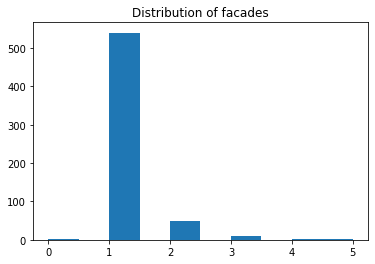

In [172]:
train_mask_paths = sorted(glob(f'{PATH_DATASET}*.xml'))
count_of_facades : list = [number_of_facades(path) for path in train_mask_paths]
plt.title('Distribution of facades')
plt.hist(count_of_facades)
plt.show()

Как видно из построенной гистограммы образцов с количеством фасадов больше 1 кратно меньше, чем с одним фасадом. Скорее всего, это негативно повлияет на качество сегментации фасадов на картинке. 
Схитрим и облегчим себе работу, оставив для рассмотрения только образцы с 1 фасадом. И сделаем наивное предположение, что фасад в таком случае покрывает всю картинку, или, как минимум, не содержит окон вне фасада здания.

PS: Я пробовал фасады отдельно сегментировать, действительно получался слабый результат. Тут вижу выход в другом датасете или аугментации того, что есть. Делать не стал, со временем как-то не сложилось :(

In [173]:
try: os.mkdir(PATH_ONE_FACADE)
except: pass

In [174]:
folder_to = PATH_ONE_FACADE

folder_from = PATH_DATASET
train_mask_paths = sorted(glob(f'{PATH_DATASET}*.xml'))

train_mask_files = []
for i in train_mask_paths:
    train_mask_files.append(i[-13:])
pref = train_mask_paths[0][:-13]
for f in os.listdir(folder_from):
    if f in train_mask_files:
        if number_of_facades(pref+f) == 1: 
            if os.path.isfile(os.path.join(folder_from, f)):
                shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))
            if os.path.isdir(os.path.join(folder_from, f)):
                os.system(f'rd /S /Q {folder_to}\\{f}')
                shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to, f))

In [175]:
len(os.listdir(PATH_ONE_FACADE))

1080

In [176]:
folder_to = PATH_ONE_FACADE
folder_from = PATH_DATASET

train_mask_paths = sorted(glob(f'{PATH_ONE_FACADE}*.xml'))
train_mask_files = []
for i in train_mask_paths:
    train_mask_files.append(i[-13:-4])

pref = train_mask_paths[0][:-13]
for f in os.listdir(folder_from):
    if (f[:-4] in train_mask_files) and (f[-4:]=='.jpg'):
        if os.path.isfile(os.path.join(folder_from, f)):
            shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))
        if os.path.isdir(os.path.join(folder_from, f)):
            os.system(f'rd /S /Q {folder_to}\\{f}')
            shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to, f))

In [177]:
len(os.listdir(PATH_ONE_FACADE))

1080

# 3 Data Preparation

In [178]:
train_img_paths = sorted(glob(f'{PATH_ONE_FACADE}*.jpg'))
train_mask_paths = sorted(glob(f'{PATH_ONE_FACADE}*.xml'))

In [179]:
X_train, X_test, y_train, y_test = train_test_split(
    train_img_paths, train_mask_paths, test_size=param.test_size, random_state=param.seed)
len(X_train), len(X_test), len(y_train), len(y_test)

(459, 81, 459, 81)

In [180]:
train_imgs = np.array([load_image(path) for path in X_train])
test_imgs = np.array([load_image(path) for path in X_test])

###  Mask windows

In [181]:
try: os.mkdir(PATH_MASK_WINDOW)
except: pass
train_mask_paths = [mask_window(path) for path in y_train]
train_window_masks = np.array(
    [binarise(load_image(path)) for path in train_mask_paths])

In [182]:
test_mask_paths = [mask_window(path) for path in y_test]
test_window_masks = np.array([binarise(load_image(path)) for path in test_mask_paths])

In [183]:
assert len(os.listdir(PATH_MASK_WINDOW)) == len(y_train) + len(y_test)

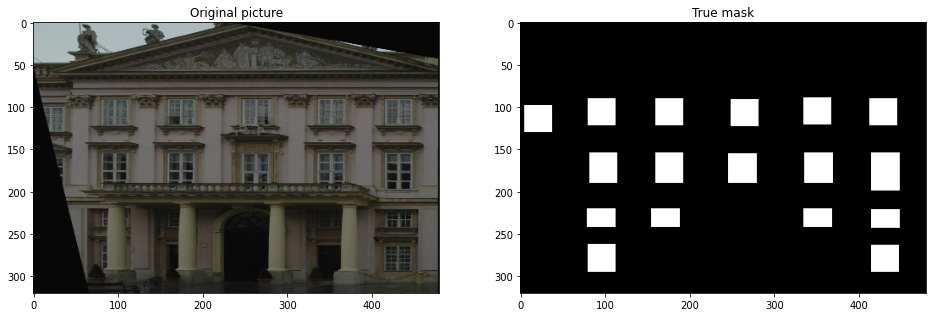

In [184]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Original picture')
plt.imshow(train_imgs[1]);

plt.subplot(1, 2, 2)
plt.title('True mask')
plt.imshow(train_window_masks[1], cmap='gray');

# 4 Modeling and Evaluation

In [185]:
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [186]:
def create_unet(height, width):
    inputs = Input((height, width, 3))

    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.3)(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5),
                       conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6),
                       conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return tf.keras.Model(inputs=[inputs], outputs=[conv10])

## Model of windows segmentation

In [187]:
model_window = create_unet(IMG_HEIGHT, IMG_WIDTH)
model_window.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 320, 480, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 320, 480, 32  128        ['conv2d_57[0][0]']              
 rmalization)                   )                                                           

In [188]:
model_window.compile(Adam(learning_rate=3e-4, decay=param.decay),
                     dice_loss,
                     metrics=[dice_coef])

In [189]:
model_window.fit(train_imgs, train_window_masks, batch_size=param.batch_size, 
                 epochs=param.epochs, validation_split=param.validation_split)

Epoch 1/40
92/92 [==============================] - 41s 361ms/step - loss: 0.6800 - dice_coef: 0.3200 - val_loss: 0.5721 - val_dice_coef: 0.4279
Epoch 2/40
92/92 [==============================] - 27s 289ms/step - loss: 0.5247 - dice_coef: 0.4757 - val_loss: 0.4706 - val_dice_coef: 0.5294
Epoch 3/40
92/92 [==============================] - 27s 291ms/step - loss: 0.3841 - dice_coef: 0.6155 - val_loss: 0.3650 - val_dice_coef: 0.6350
Epoch 4/40
92/92 [==============================] - 26s 282ms/step - loss: 0.3049 - dice_coef: 0.6952 - val_loss: 0.2925 - val_dice_coef: 0.7075
Epoch 5/40
92/92 [==============================] - 26s 280ms/step - loss: 0.2668 - dice_coef: 0.7332 - val_loss: 0.2637 - val_dice_coef: 0.7363
Epoch 6/40
92/92 [==============================] - 26s 278ms/step - loss: 0.2547 - dice_coef: 0.7455 - val_loss: 0.2859 - val_dice_coef: 0.7141
Epoch 7/40
92/92 [==============================] - 27s 292ms/step - loss: 0.2484 - dice_coef: 0.7515 - val_loss: 0.2614 - val_dic

## Evaluation of windows segmentation

In [190]:
test_iter = test_img_generator(X_test)
pred_windows = model_window.predict(test_iter)

81/81 [==============================] - 3s 17ms/step


In [191]:
dc : list = []
for i in range(len(pred_windows)):
    dc.append(dice_coef(test_window_masks[i], pred_windows[i]).numpy())
print(f'dice_coef for test samples: {sum(dc) / len(dc):.4f}')

dice_coef for test samples: 0.8293


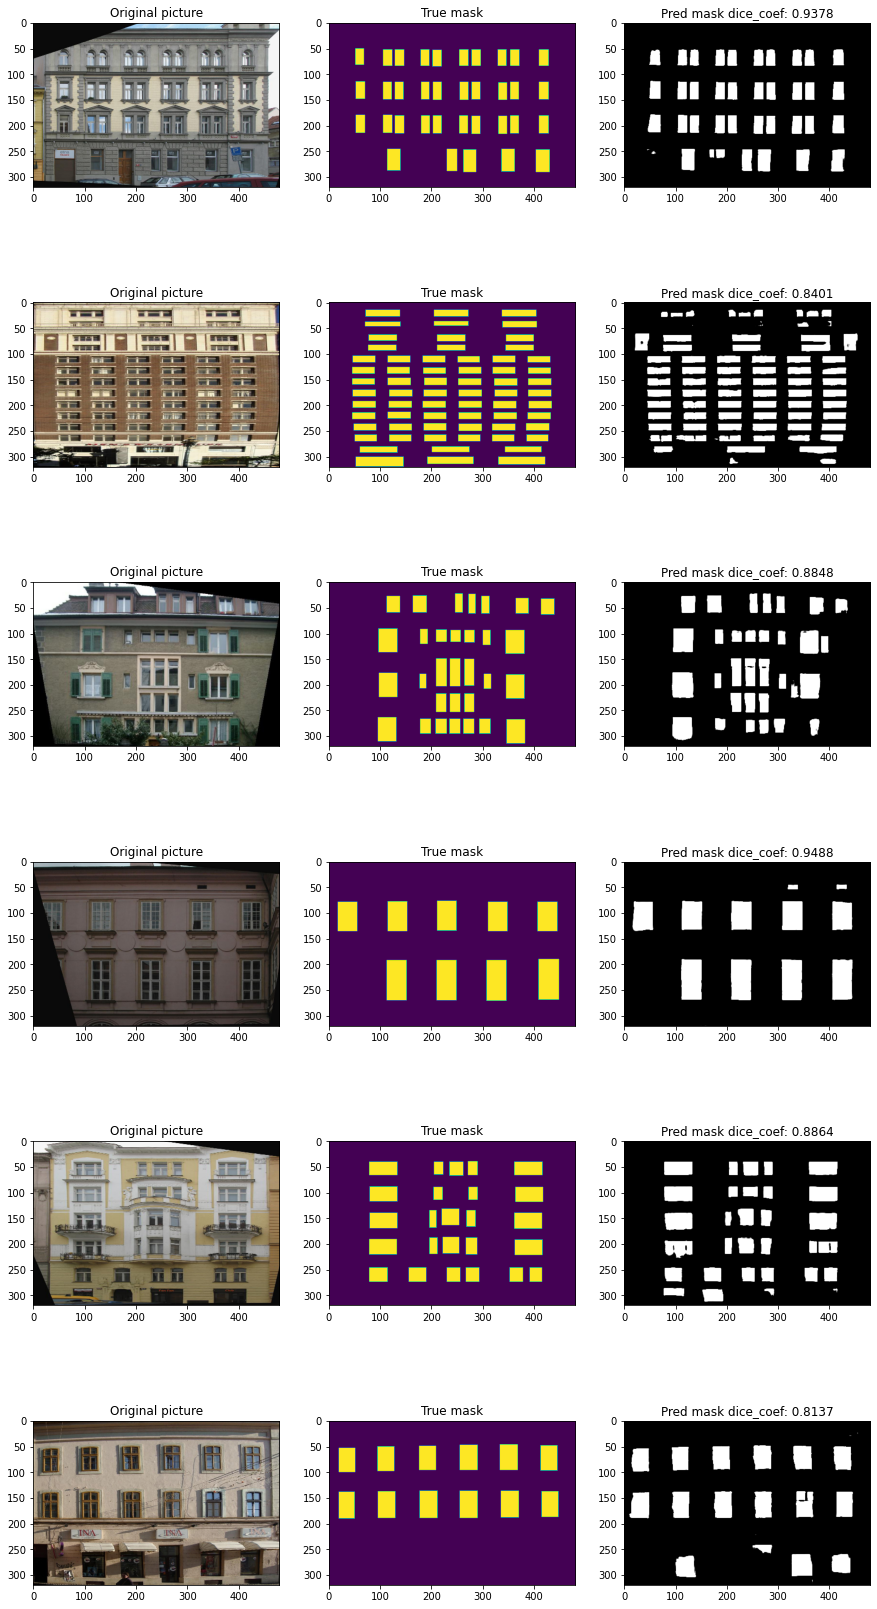

In [192]:
SHOW_SAMPLES = min(len(pred_windows), 6)

fig = plt.figure(0, figsize=(15, 5*SHOW_SAMPLES))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 3, 3*i+1)
    plt.title('Original picture')
    plt.imshow(test_imgs[i])
    plt.subplot(SHOW_SAMPLES, 3, 3*i+2)
    plt.title('True mask')
    plt.imshow(test_window_masks[i])
    plt.subplot(SHOW_SAMPLES, 3, 3*i+3)
    plt.title(f'Pred mask dice_coef: {dice_coef(test_window_masks[i], pred_windows[i]).numpy():.4f}')
    plt.imshow(pred_windows[i], cmap='gray')

# 5 Number of floors

Сделаем наивное предположение, что этажи разделены "безоконным" пространством

In [193]:
pred_floor_number : list = []
for pred_img in pred_windows:
    gray = (pred_img*255).astype(int)
    gray = np.array(gray, dtype=np.uint8)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, param.trshld_floor*dist_transform.max(),255,0)
    cnt :int = 0
    is_window : bool = True
    for row in sure_fg:
        if len(np.unique(row)) > 1:
            if is_window:
                cnt += 1
                is_window = False
        else:
            is_window = True
    pred_floor_number.append(cnt)

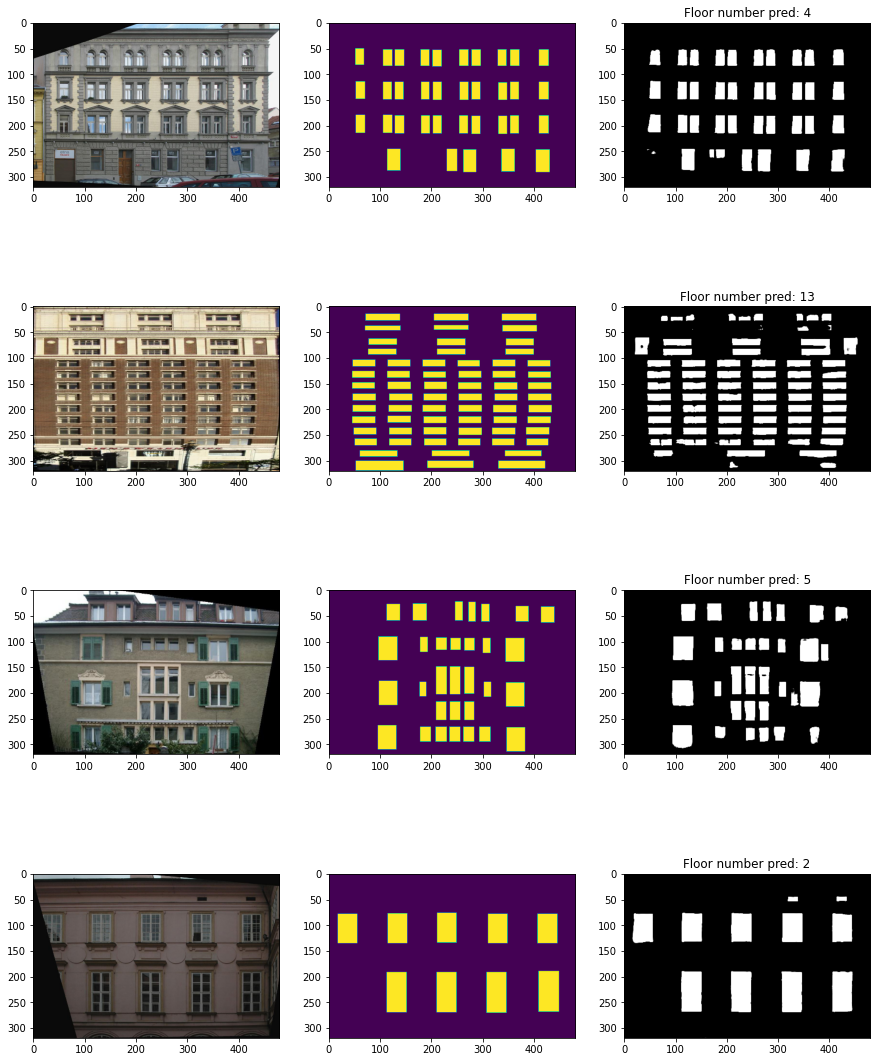

In [194]:
SHOW_SAMPLES = min(len(pred_windows), 4)

fig = plt.figure(0, figsize=(15, 5*SHOW_SAMPLES))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 3, 3*i+1)
    plt.imshow(test_imgs[i])
    plt.subplot(SHOW_SAMPLES, 3, 3*i+2)
    plt.imshow(test_window_masks[i])
    plt.subplot(SHOW_SAMPLES, 3, 3*i+3)
    plt.title(f'Floor number pred: {pred_floor_number[i]}')
    plt.imshow(pred_windows[i], cmap='gray')

# 6 Number of windows

In [195]:
num_of_wins : np.array = []
for path in y_test:
    num_of_wins.append(number_of_windows(path))

In [196]:
pred_win_3_chanel : list = []
for i in range(len(pred_windows)):
    pred_win_3_chanel.append(np.concatenate((pred_windows[i], pred_windows[i], pred_windows[i]), axis=2))
pred_win_3_chanel = np.array(pred_win_3_chanel)
print(pred_win_3_chanel.shape)

(81, 320, 480, 3)


In [197]:
pred_markers : np.array = []
pred_num_of_wins : np.array = []
for i in range(len(pred_win_3_chanel)):
    gray = cv2.cvtColor(pred_win_3_chanel[i], cv2.COLOR_BGR2GRAY)
    gray = (gray*255).astype(int)
    gray = np.array(gray, dtype=np.uint8)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(thresh,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, param.trshld_window*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    arr = (pred_win_3_chanel[i] * 255).astype(int)
    arr = np.array(arr, dtype=np.uint8)   
    markers = cv2.watershed(arr, markers)
    pred_markers.append(markers)
    pred_num_of_wins.append(len(np.unique(markers))-2)

In [198]:
print('Accuracy of prediction num_of_wins:', accuracy_score(num_of_wins, pred_num_of_wins))

Accuracy of prediction num_of_wins: 0.07407407407407407


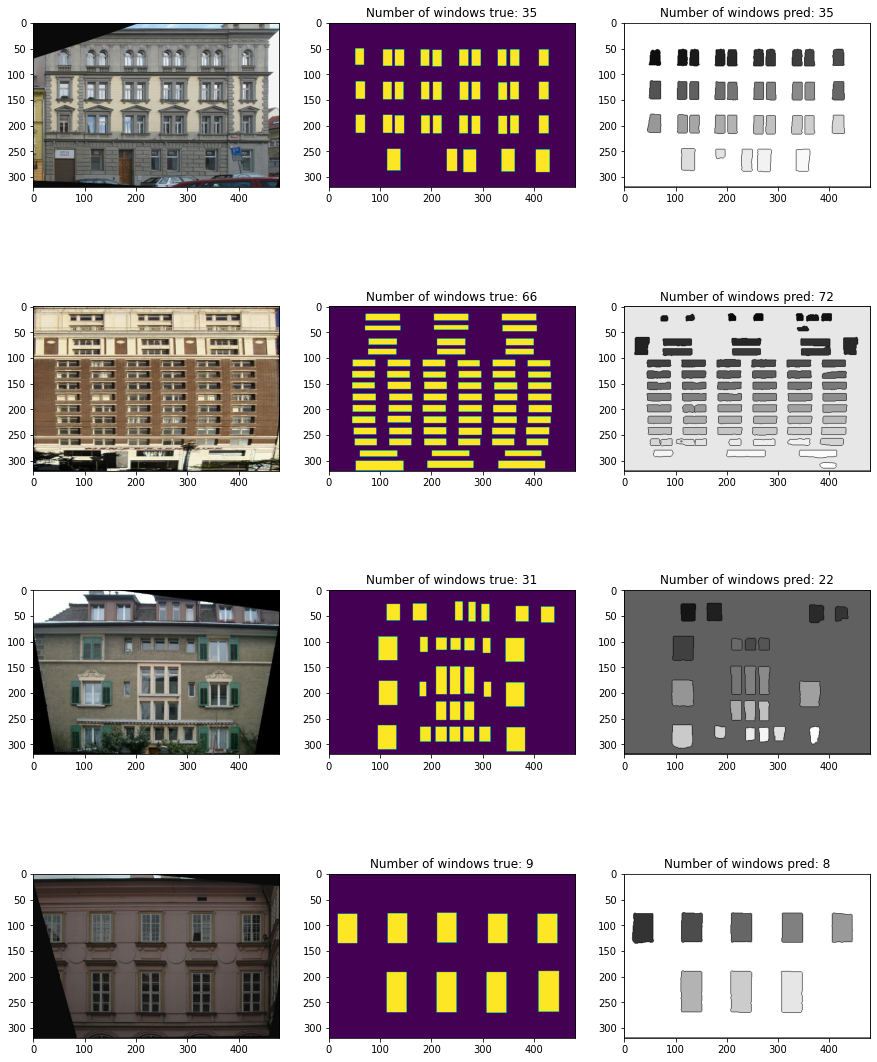

In [199]:
SHOW_SAMPLES = min(len(pred_markers), 4)

fig = plt.figure(0, figsize=(15, 5*SHOW_SAMPLES))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 3, 3*i+1)
    plt.imshow(test_imgs[i])
    plt.subplot(SHOW_SAMPLES, 3, 3*i+2)
    plt.imshow(test_window_masks[i])
    plt.title(f'Number of windows true: {num_of_wins[i]}')
    plt.subplot(SHOW_SAMPLES, 3, 3*i+3)
    plt.title(f'Number of windows pred: {pred_num_of_wins[i]}')
    plt.imshow(pred_markers[i], cmap='gray')

# 7.Conclusions and References

1. https://github.com/a4tunado/lectures/blob/master/007/007-segmentation.ipynb
3. https://github.com/a4tunado/lectures/blob/master/003/003-watershed.ipynb
4. https://www.kaggle.com/code/kmader/vgg16-u-net-on-carvana